<a href="https://colab.research.google.com/github/cleysonl/Pytorch/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Style transfer with PyTorch using VGG19**

In [25]:
!pip install torch torchvision
!pip3 install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/10/5c/0e94e689de2476c4c5e644a3bd223a1c1b9e2bdb7c510191750be74fa786/Pillow-6.2.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## **Initialize Model VGG19**

In [0]:
vgg = models.vgg19(pretrained= True).features

In [0]:
for param in vgg.parameters():
  param.requires_grad_(False)


In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## **Function load_image**

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB') # we set the color space of the imported image to be a standard 'RGB' image
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

   # transform the uploaded image for the model
  in_transform = transforms.Compose([ transforms.Resize(size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
  
  image = in_transform(image).unsqueeze(0) # unsqueeze(0) to an extra dimensionality to the image
  return image

### **Uploading the pictures for the Style transfer**

In [0]:
content = load_image('terro.jpg').to(device)
style = load_image('oldguitarist.jpg', shape = content.shape[-2:]).to(device)

### **Function to convert image: im_convert**

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze() ############ why?????????????
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image


(-0.5, 399.5, 399.5, -0.5)

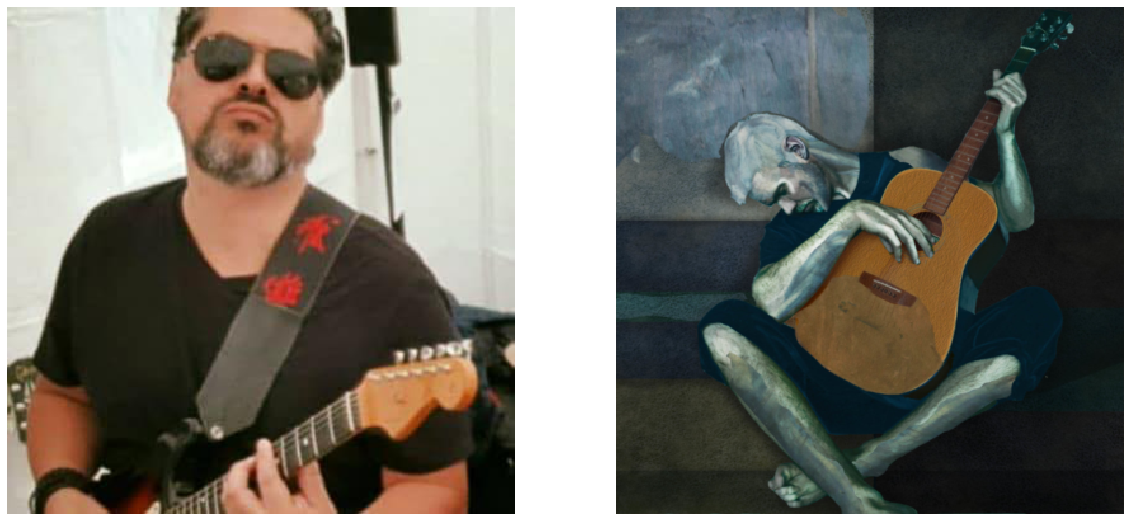

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## **Function get_features**

In [0]:
def get_features(image, model):
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # content extraction
            '28': 'conv5_1'
            }
  features = {}
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features


In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

## **Gram Matrix**

In [0]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## **Optimization**

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
 
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 20000
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  248299.59375
Iteration:  300


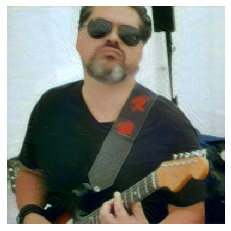

Total loss:  177573.515625
Iteration:  600


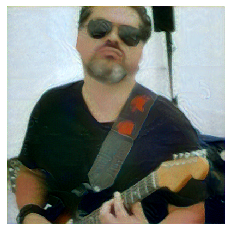

Total loss:  134445.546875
Iteration:  900


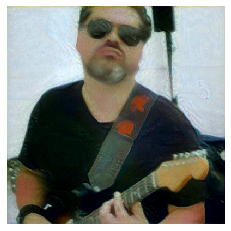

Total loss:  106038.40625
Iteration:  1200


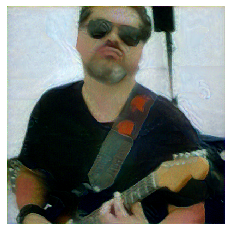

Total loss:  85560.0
Iteration:  1500


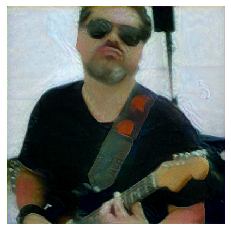

Total loss:  69681.625
Iteration:  1800


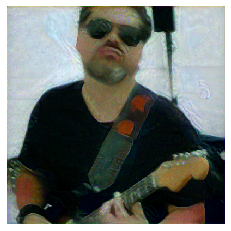

Total loss:  57268.20703125
Iteration:  2100


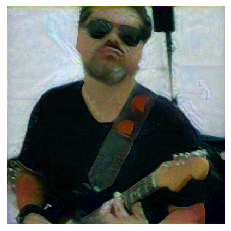

Total loss:  47841.31640625
Iteration:  2400


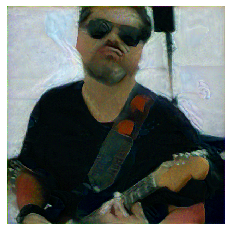

Total loss:  40876.625
Iteration:  2700


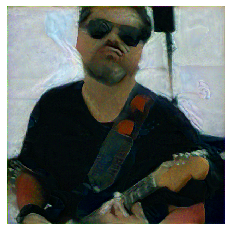

Total loss:  35590.48828125
Iteration:  3000


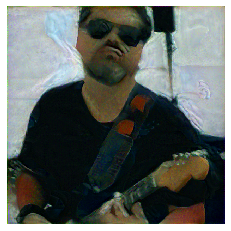

Total loss:  31521.80859375
Iteration:  3300


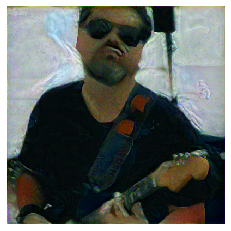

Total loss:  28106.787109375
Iteration:  3600


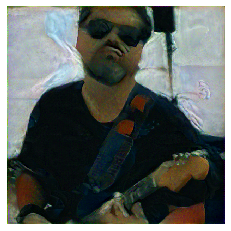

Total loss:  25302.935546875
Iteration:  3900


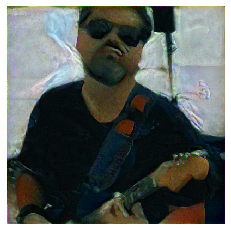

Total loss:  22686.76953125
Iteration:  4200


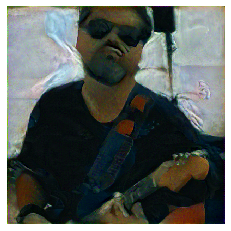

Total loss:  20348.201171875
Iteration:  4500


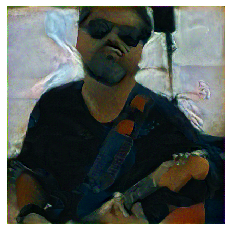

Total loss:  17875.30859375
Iteration:  4800


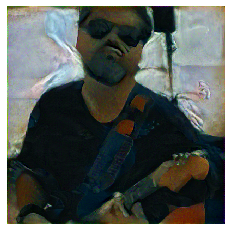

Total loss:  15929.3974609375
Iteration:  5100


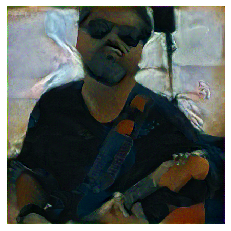

Total loss:  13486.1962890625
Iteration:  5400


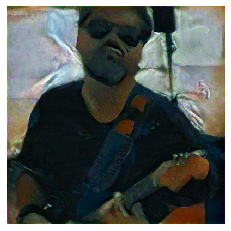

Total loss:  11460.59375
Iteration:  5700


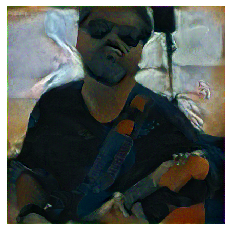

Total loss:  10121.578125
Iteration:  6000


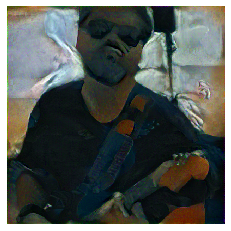

Total loss:  9022.0771484375
Iteration:  6300


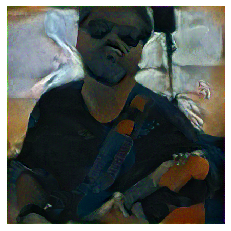

Total loss:  8150.98779296875
Iteration:  6600


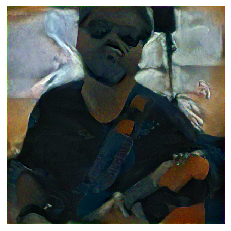

Total loss:  7467.6083984375
Iteration:  6900


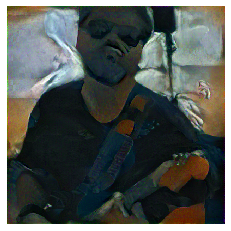

Total loss:  7055.79248046875
Iteration:  7200


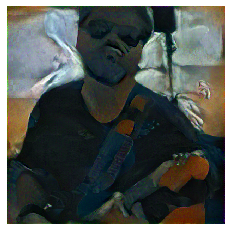

Total loss:  6581.63427734375
Iteration:  7500


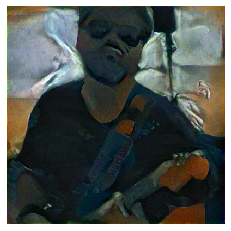

Total loss:  6295.78955078125
Iteration:  7800


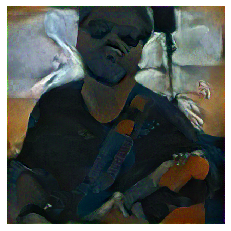

Total loss:  5973.77294921875
Iteration:  8100


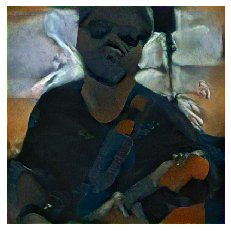

Total loss:  5835.33447265625
Iteration:  8400


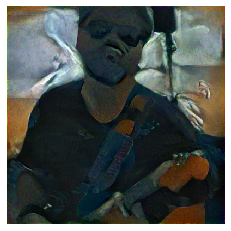

Total loss:  5746.1630859375
Iteration:  8700


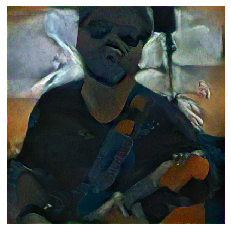

Total loss:  5526.79736328125
Iteration:  9000


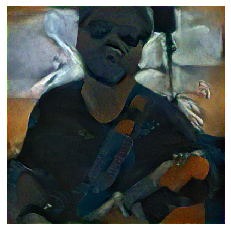

Total loss:  5471.37158203125
Iteration:  9300


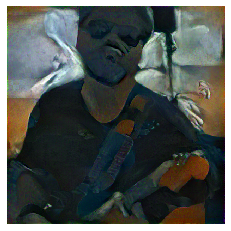

Total loss:  5249.037109375
Iteration:  9600


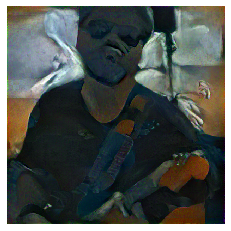

Total loss:  5165.65673828125
Iteration:  9900


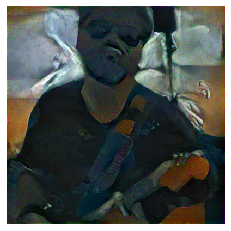

Total loss:  5167.7666015625
Iteration:  10200


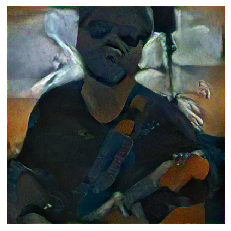

Total loss:  5176.4326171875
Iteration:  10500


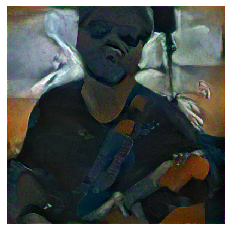

Total loss:  4982.00146484375
Iteration:  10800


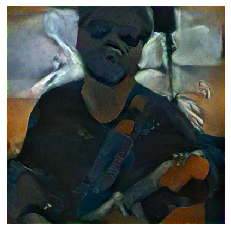

Total loss:  5005.6943359375
Iteration:  11100


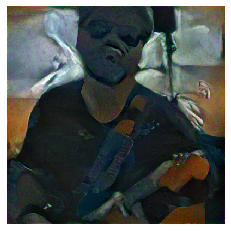

Total loss:  5014.14501953125
Iteration:  11400


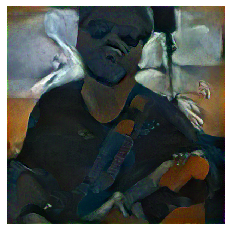

Total loss:  4891.7255859375
Iteration:  11700


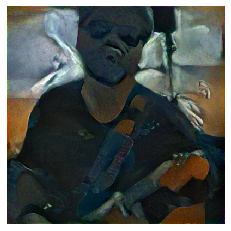

Total loss:  4951.58056640625
Iteration:  12000


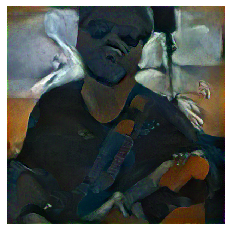

Total loss:  4765.92529296875
Iteration:  12300


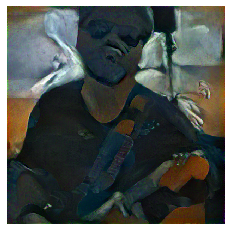

Total loss:  5455.34912109375
Iteration:  12600


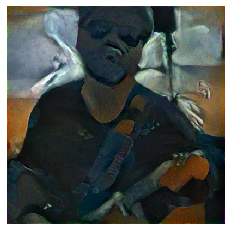

Total loss:  4776.2373046875
Iteration:  12900


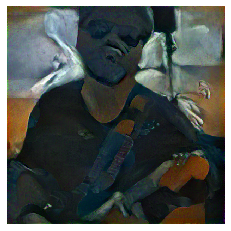

Total loss:  4649.52685546875
Iteration:  13200


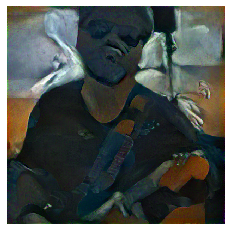

Total loss:  4626.658203125
Iteration:  13500


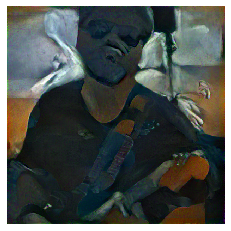

Total loss:  4603.20654296875
Iteration:  13800


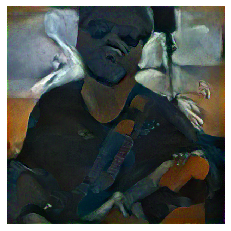

Total loss:  4595.55322265625
Iteration:  14100


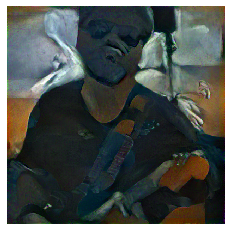

Total loss:  4595.37060546875
Iteration:  14400


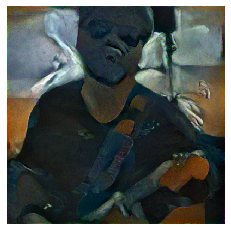

Total loss:  4533.09912109375
Iteration:  14700


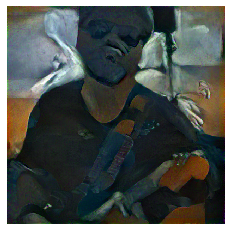

In [0]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

## **Saving the Style transfer into a video**

In [0]:
import cv2 
 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
 
for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
 
vid.release()

### **Downloading the video**

In [0]:
from google.colab import files
files.download('output.mp4')